In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import graphviz as gr
import dowhy
from dowhy import CausalModel
plt.style.use("fivethirtyeight")

/Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate data

In [2]:
class GPSMemorySCM:
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
    
    def sample(self, sample_size=100, treatment_value=None):
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)

        if treatment_value:
            gps = np.array([treatment_value] *sample_size)
        else:
            gps = u_x + 0.7 * u
        
        hippocampus = -0.6 * gps + .25 * u_z
        memory = 0.7 * hippocampus + 0.25 * u
        return gps, hippocampus, memory

    def intervene(self, treatment_value, sample_size=100):
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)        

In [17]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [26]:
# scm = GPSMemorySCM()
# gps_obs, hippocampus_obs, memory_obs = scm.sample(1000)
# df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, memory_obs]).T, columns=["X", "Z", "Y"])

# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, memory_obs]).T, columns=['X', 'Z', 'Y'])

# Step 1 - modeling the problem
- Creating a graph representing our problem -> GML
- Instantiating DoWhy's `CausalModel` object using this graph

In [34]:
# gml_graph = """
# graph [
#     directed 1

#     node [
#         id "X"
#         label "X"
#     ]

#     node [
#         id "Z"
#         label "Z"
#     ]

#     node [
#         id "Y"
#         label "Y"
#     ]

#     node [
#         id "U"
#         label "U"
#     ]

#     edge [
#         source "X"
#         target "Z"
#     ]

#     edge [
#         source "Z"
#         target "Y"
#     ]

#     edge [
#         source "U"
#         target "X"
#     ]

#     edge [
#         source "U"
#         target "Y"
#     ]
# ]
# """

gml_graph = """
graph [
    directed 1
    
    node [
        id "X" 
        label "X"
    ]    
    node [
        id "Z"
        label "Z"
    ]
    node [
        id "Y"
        label "Y"
    ]
    node [
        id "U"
        label "U"
    ]
    
    edge [
        source "X"
        target "Z"
    ]
    edge [
        source "Z"
        target "Y"
    ]
    edge [
        source "U"
        target "X"
    ]
    edge [
        source "U"
        target "Y"
    ]
]
"""



In [35]:
model = CausalModel(
    data=df,
    treatment="X",
    outcome="Y",
    graph=gml_graph
) 

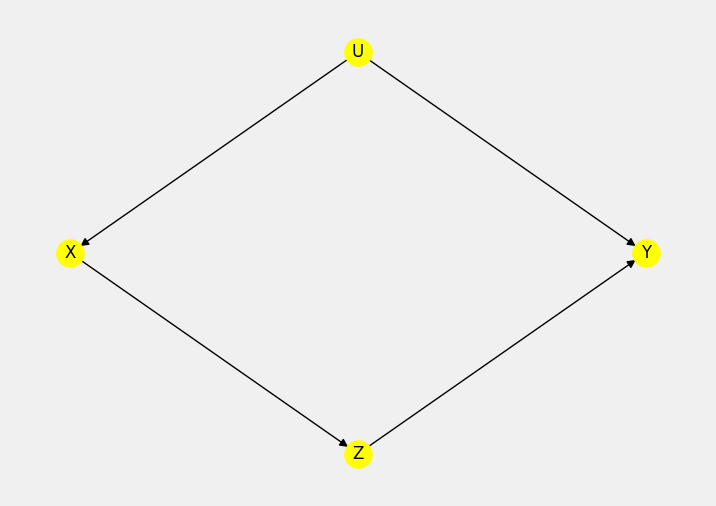

In [36]:
model.view_model()

# Step 2 - Identifying the estimand(s)

In [41]:
estimand = model.identify_effect()

In [42]:
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



# Step 3 - obtaining estimates

In [39]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="frontdoor.two_stage_regression"
)

In [43]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='frontdoor.two_stage_regression')

print(f'Estimate of causal effect (linear regression): {estimate.value}')

Estimate of causal effect (linear regression): -0.3382740943385683


# Step 4 - refute

In [44]:
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fractio=.4

)

In [45]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.3382740943385683
New effect:-0.3385146558763257
p value:0.8999999999999999



# Full Example

In [47]:
SAMPLE_SIZE = 1_000
S = np.random.random(SAMPLE_SIZE)
Q = .2*S + .67*np.random.random(SAMPLE_SIZE)
X = .14*Q + .4*np.random.random(SAMPLE_SIZE)
Y = .7*X + .11*Q + .32*S + .24*np.random.random(SAMPLE_SIZE)
P = .43*X + .21*Y + .22*np.random.random(SAMPLE_SIZE)

df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=["S", "Q", "X", "Y", "P"])

## Step 1 - Define the model

In [69]:
nodes = ["S", "Q", "X", "Y", "P"]
edges = ["SQ", "SY", "QX", "QY", "XP", "YP", "XY"]

gml_string = "graph [directed 1\n"
for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += "]"

In [70]:

model = CausalModel(
    data=df,
    treatment="X",
    outcome="Y",
    graph=gml_string
)

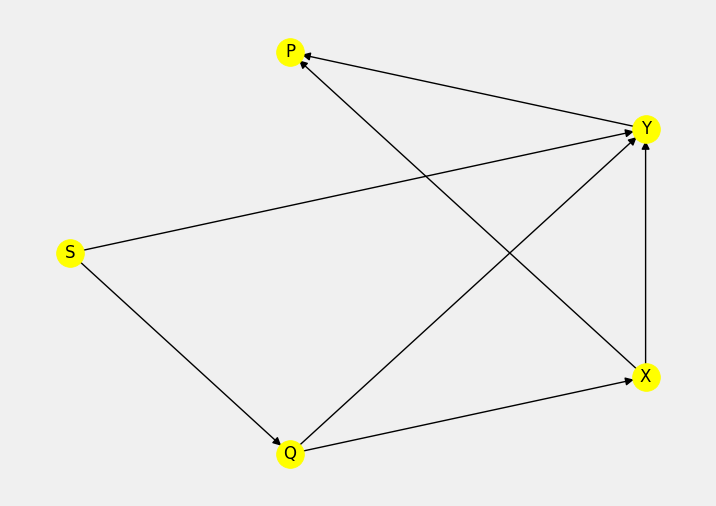

In [72]:
model.view_model()

## Step 2 - getting the estimand

In [73]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Step 3 - estimate

In [74]:
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="backdoor.econml.dml.DML",
    method_params={
        "init_params": {
            "model_y": GradientBoostingRegressor(),
            "model_t": GradientBoostingRegressor(),
            "model_final": LassoCV(fit_intercept=False)
        } ,
        "fit_params": {}}
)

/Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behavio

In [76]:
print(f"Estimate of causal effect (DML): {estimate.value}")

Estimate of causal effect (DML): 0.7196614541351716


## Step 4 - refute

In [77]:
random_cause = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="random_common_cause"
)

print(random_cause)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Add a random common cause
Estimated effect:0.7196614541351716
New effect:0.7096884986846292
p value:0.45999999999999996



In [78]:
placebo_refuter = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="placebo_treatment_refuter"
)

print(placebo_refuter)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Use a Placebo Treatment
Estimated effect:0.7196614541351716
New effect:0.0
p value:2.0



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


# GCM API

In [79]:
import networkx as nx
from dowhy import gcm

SAMPLE_SIZE = 1_000
S = np.random.random(SAMPLE_SIZE)
Q = 0.2 * S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T,
                  columns=["S", "Q", "X", "Y", "P"])

In [81]:
edges = ["SQ", "SY", "QX", "QY", "XP", "YP", "XY"]
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

In [82]:
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

In [83]:
causal_model.set_causal_mechanism("S", gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism("X", gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism("Y", gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism("P", gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism("Q", gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))


In [85]:
gcm.fit(causal_model, df)
gcm.arrow_strength(causal_model, "Y")

Fitting causal mechanism of node P: 100%|██████████| 5/5 [00:00<00:00, 760.44it/s]


{('Q', 'Y'): 0.0004850196799524171,
 ('S', 'Y'): 0.008984423028550818,
 ('X', 'Y'): 0.006579106706714717}